# <a style="background-color:black;color:white"> Exploration 9 </a>

# 프로젝트: 폐렴 진단기 성능개선

### [평가 루브릭]

#### (1) 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
* 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

#### (2) 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
* regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

#### (3) 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
* Accuracy 기준 85%에 도달하였다.

# Step 1. 실험환경 Set-up

필요한 패키지들 import 하기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings(action='ignore')

필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

# Step 2. 데이터 준비하기

데이터 개수 확인하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train, val, test 데이터 수의 비는 89%, 10.7%, 0.3% 이므로 val 데이터가 매우 부족
train과 val 데이터를 모아서 80:20으로 분리하기!

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [7]:
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4185
624
1047


파일 경로에 NORMAL이 있으면 정상 이미지, PNEUMONIA가 있으면 폐렴 이미지 이므로 개수를 세어보자!

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


CNN 모델의 경우 클래스 별 train 데이터의 밸런스가 좋아야 성능이 좋다. -> 추후에 처리할 예정  
test와 val 데이터는 훈련하는 것이 아니기에 상관없음.

tf.data 인스턴스 만들기!  
학습 과정에서 mini-batch로 작업할 수 있게 tf.data 인스턴스를 생성한다.

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train 데이터셋, validation 데이터셋 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재는 이미지만 있고 폐렴 여부에 대한 레이블이 없음.  
그러므로 파일 경로를 이용해 레이블 데이터를 생성해주는 함수를 정의한다.

In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈를 통일 시키고, GPU를 효율적으로 사용하기 위해 이미지 사이즈를 줄이는 함수를 정의한다!  
위에서 정의한 함수를 포함하여 레이블 데이터도 동시에 추가한다.

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

위 함수를 이용해서 train과 val 데이터셋을 만든다.  
num_parallel_calls 파라미터에 처음에 생성한 AUTOTUNE 변수를 입력하여 데이터 로드를 더 빠르게 한다.

In [53]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

데이터셋이 제대로 만들어 졌는지 확인!

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test 데이터셋도 만들고 개수를 확인한다.

In [54]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.  
tf.data 파이프라인을 사용하여 데이터를 변화해주는 함수를 정의한다!

여기서 data augmentation을 추가한다!  
의료영상의 경우 데이터수가 작으므로 데이터수를 늘려줄 목적으로 좌우반전된 영상을 추가한다.  
그러나 의료영상의 경우 이러한 변형된 데이터가 입력되는 경우가 거의 없기에 성능의 향상을 가져올지는 미지수!!!

In [55]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 버퍼사이즈를 유지한채 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 여러 번 데이터셋을 사용할 수 있게 해줌
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어오기 때문에, 
                                            # GPU에서 데이터를 학습하는 동안 CPU에서 다음 데이터를 준비할 수 있어 
                                            # 리소스의 유휴 상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

batch내의 데이터를 시각화해주는 함수를 정의하고, train의 첫 번째 batch를 불러와 이미지와 레이블로 나누고 출력해준다.

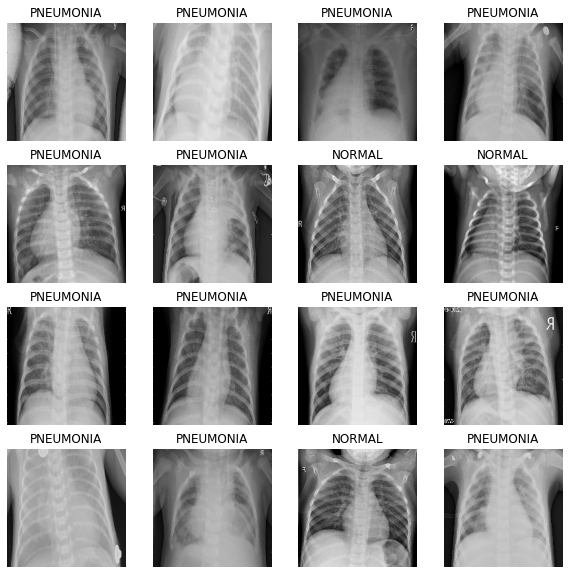

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

Convolution block을 만들자!  
Convolutuin을 두 번 해주고, batch normalization을 통해 Gradient vanishing, Gradient Exploding을 해결한다.  
마지막으로 Max pooling을 해준다.

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense block 만들기!  
Batch normalization과 Dropout을 동시에 사용한 것이 성능을 높일 수 있을지는 지켜봐야 함!!!!

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

위에서 정의한 block들을 활용해 모델을 생성하는 함수를 정의한다!

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

정상 이미지와 폐렴 이미지 중 폐렴 이미지가 더 많이 있었던 불균형한 문제를 해결하자!  
Weight balancing 기법을 활용!!  

> Weight balancing  
-> training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

weight_for_0: 'Normal' 이미지에 사용할 weight  
weight_for_1: 'Pneumonia' 이미지에 사용할 weight  
\* 전체 데이터 수에 반비례 하도록 설계  

model.fit()을 통해 학습할 때 class_weight 파라미터로 입력해준다.

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련 [모델 (1)]

모델을 저장하기 위한 체크포인트 선언

In [43]:
mc = tf.keras.callbacks.ModelCheckpoint('{epoch:02d}-{val_loss:.5f}.h5', monitor='val_loss', mode='min', save_best_only=True, save_freq='epoch')

빠른 처리를 위해 GPU를 활용할 예정이므로 GPU를 선택해준다.  
모델을 생성하는 함수를 통해 모델을 생성해주며,  
이미지의 레이블이 두 개 이므로 Binary cross entropy loss를 활용한다.

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 학습한다.  
class_weight를 입력해주어 데이터으 imbalance 문제를 해결한다.

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc]
    )

Epoch 1/25
261/261 [==============================] - 61s 187ms/step - loss: 0.4049 - accuracy: 0.8015 - precision: 0.9477 - recall: 0.7761 - val_loss: 0.7570 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2321 - accuracy: 0.9092 - precision: 0.9706 - recall: 0.9053 - val_loss: 1.3400 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2186 - accuracy: 0.9171 - precision: 0.9726 - recall: 0.9143 - val_loss: 1.0193 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2023 - accuracy: 0.9229 - precision: 0.9745 - recall: 0.9206 - val_loss: 0.1011 - val_accuracy: 0.9712 - val_precision: 0.9933 - val_recall: 0.9673
Epoch 5/25
261/261 [==============================] - 51s 197ms/step - loss: 0.1945 - accura

# Step 7. 결과 확인과 시각화

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss 변화를 시각화

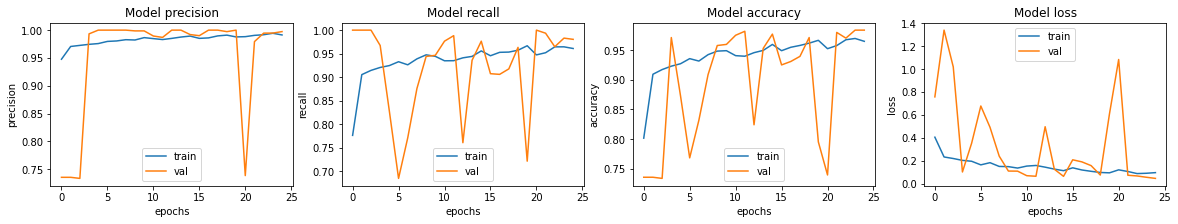

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

모델 평가를 위해 test 데이터셋에 대한 loss, accuracy, precision, recall을 출력

In [26]:
#model.load_weights("best_model.h5")

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.8272 - accuracy: 0.7772 - precision: 0.7390 - recall: 0.9949
Loss: 0.8272004723548889,
Accuracy: 0.7772436141967773,
Precision: 0.739047646522522,
Recall: 0.9948717951774597


test recall은 99.4%를 기록하며 높은 값을 보였지만, test accuracy는 77.7%로 만족스럽지 못한 결과를 얻었다.

---
# 다른 방법 시도!

**Optimizer를 RMSProp으로!! [모델 (2)]**

In [28]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc]    
    )


Epoch 1/25
261/261 [==============================] - 59s 189ms/step - loss: 0.4226 - accuracy: 0.8034 - precision: 0.9493 - recall: 0.7773 - val_loss: 0.7347 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2800 - accuracy: 0.8913 - precision: 0.9676 - recall: 0.8835 - val_loss: 1.1963 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2403 - accuracy: 0.9011 - precision: 0.9700 - recall: 0.8947 - val_loss: 0.2654 - val_accuracy: 0.8913 - val_precision: 0.9969 - val_recall: 0.8547
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2217 - accuracy: 0.9148 - precision: 0.9674 - recall: 0.9163 - val_loss: 0.0844 - val_accuracy: 0.9750 - val_precision: 0.9868 - val_recall: 0.9790
Epoch 5/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1907 - accura

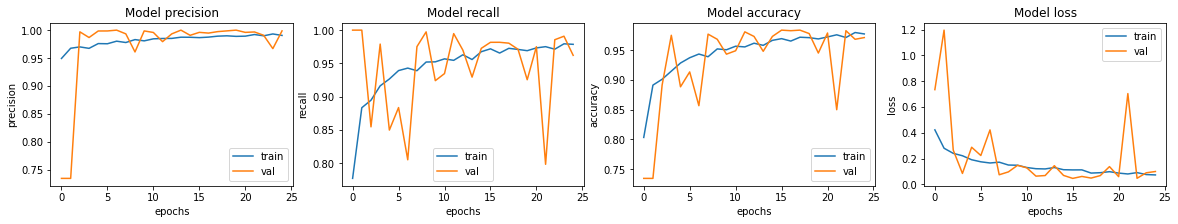

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
#model.load_weights("best_model.h5")

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 0.9716 - accuracy: 0.8109 - precision: 0.7822 - recall: 0.9667
Loss: 0.9715568423271179,
Accuracy: 0.8108974099159241,
Precision: 0.7821576595306396,
Recall: 0.9666666388511658


결과에서 보이듯 RMSProp 옵티마이저를 적용했을 때 더 효과가 좋으니, 다음 모델부터는 모두 RMSProp으로 활용예정

**혹시... Data augmentation을 적용하지 않는다면??? [모델 (3)]**

In [32]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_org(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 버퍼사이즈를 유지한채 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 여러 번 데이터셋을 사용할 수 있게 해줌
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어오기 때문에, 
                                            # GPU에서 데이터를 학습하는 동안 CPU에서 다음 데이터를 준비할 수 있어 
                                            # 리소스의 유휴 상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training_org(train_ds)
val_ds = prepare_for_training_org(val_ds)

In [34]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [ True  True  True False  True  True False  True  True  True False False
  True  True  True False]


In [35]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [36]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc]
    )

Epoch 1/25
261/261 [==============================] - 59s 190ms/step - loss: 0.4150 - accuracy: 0.7921 - precision: 0.9455 - recall: 0.7647 - val_loss: 0.8375 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.2588 - accuracy: 0.9071 - precision: 0.9683 - recall: 0.9047 - val_loss: 1.2516 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2043 - accuracy: 0.9246 - precision: 0.9729 - recall: 0.9245 - val_loss: 0.1381 - val_accuracy: 0.9481 - val_precision: 0.9372 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1873 - accuracy: 0.9332 - precision: 0.9757 - recall: 0.9332 - val_loss: 0.3264 - val_accuracy: 0.8952 - val_precision: 0.9985 - val_recall: 0.8586
Epoch 5/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1741 - accura

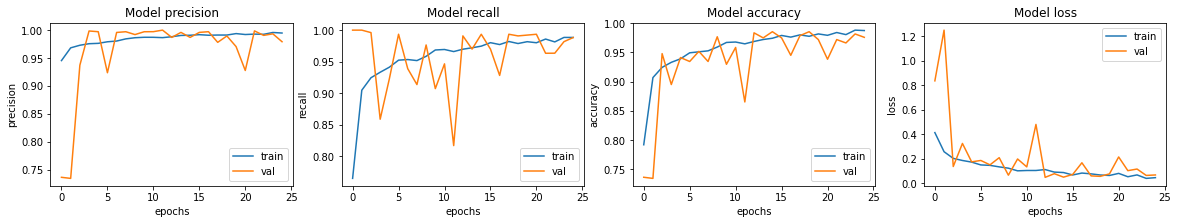

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
model.load_weights()

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.8272 - accuracy: 0.7772 - precision: 0.7390 - recall: 0.9949
Loss: 0.8272004723548889,
Accuracy: 0.7772436141967773,
Precision: 0.739047646522522,
Recall: 0.9948717951774597


베스트 모델 저장이 제대로 되지 않은듯 기본 모델과 같은 결과가 나왔다.

**train과 val 데이터를 다시 나눈지 않고 처음 개수 그대로 학습하면??? [모델 (4)]**

In [45]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [46]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1341
Pneumonia images count in training set: 3875


In [47]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [48]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 5216
Validating images count: 16


In [49]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [50]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [51]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [56]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [57]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc]
    )

Epoch 1/25
326/326 [==============================] - 59s 132ms/step - loss: 0.6010 - accuracy: 0.6956 - precision: 0.8758 - recall: 0.6877 - val_loss: 0.8713 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/25
326/326 [==============================] - 42s 128ms/step - loss: 0.6743 - accuracy: 0.7559 - precision: 0.8087 - recall: 0.8795 - val_loss: 1.3694 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/25
326/326 [==============================] - 42s 129ms/step - loss: 0.7374 - accuracy: 0.7859 - precision: 0.8126 - recall: 0.9252 - val_loss: 1.7666 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/25
326/326 [==============================] - 42s 129ms/step - loss: 0.7901 - accuracy: 0.7970 - precision: 0.8137 - recall: 0.9425 - val_loss: 1.9632 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/25
326/326 [==============================] - 42s 129ms/step - loss: 0.8135 - accura

39/39 [==============================] - 4s 107ms/step - loss: 1.2325 - accuracy: 0.6907 - precision: 0.6690 - recall: 1.0000
Loss: 1.2324538230895996,
Accuracy: 0.6907051205635071,
Precision: 0.6689537167549133,
Recall: 1.0


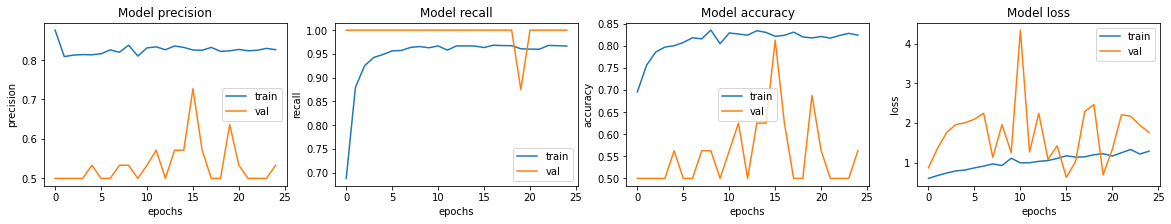

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
    
#model.load_weights()

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [60]:
model.load_weights('16-0.62649.h5')

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 0.7764 - accuracy: 0.7340 - precision: 0.7066 - recall: 0.9821
Loss: 0.7763718366622925,
Accuracy: 0.7339743375778198,
Precision: 0.7066420912742615,
Recall: 0.9820512533187866


**keras의 ```ImageDataGenerator```를 이용해보자!! [모델 (5)]**

다양한 방식으로 편하게 data augmentation을 진행해주는 ```ImageDataGenerator```를 이용하여 학습을 진행해보자.  
코드는 아래 링크를 참고했다.  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
train_datagen = ImageDataGenerator(  # train 데이터를 생성
        rescale=1./255, # 이미지의 스케일을 조절
        shear_range=0.2, # 이미지의 기울기 조절
        zoom_range=0.2, # 이미지를 크롭
        horizontal_flip=True) #이미지를 수평방향으로 반전
test_datagen = ImageDataGenerator(rescale=1./255) # val 데이터는 학습을 하는 것이 아닌 검증을 위한 것이므로 스케일만 조절
train_generator = train_datagen.flow_from_directory(
        ROOT_PATH + '/chest_xray/data/train',
        target_size=(180, 180),
        batch_size=BATCH_SIZE,
        class_mode='binary') # 클래스가 두 개 이므로 'binary'
validation_generator = test_datagen.flow_from_directory(
        ROOT_PATH + '/chest_xray/data/val',
        target_size=(180, 180),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [63]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc]
    )

Epoch 1/25
326/326 [==============================] - 86s 257ms/step - loss: 0.4381 - accuracy: 0.7843 - precision: 0.9421 - recall: 0.7561 - val_loss: 0.8988 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/25
326/326 [==============================] - 83s 256ms/step - loss: 0.3200 - accuracy: 0.8685 - precision: 0.9604 - recall: 0.8583 - val_loss: 0.5308 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/25
326/326 [==============================] - 83s 256ms/step - loss: 0.2624 - accuracy: 0.8957 - precision: 0.9661 - recall: 0.8908 - val_loss: 2.4552 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
326/326 [==============================] - 83s 254ms/step - loss: 0.2458 - accuracy: 0.9116 - precision: 0.9690 - recall: 0.9102 - val_loss: 1.6935 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 5/25
326/326 [==============================] - 83s 255ms/step - loss: 0.2224 

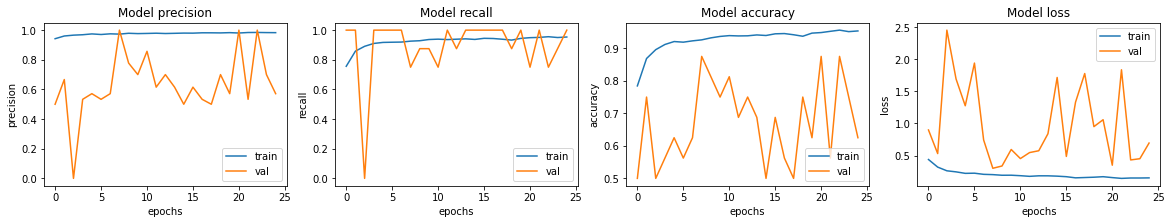

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
#model.load_weights("best_model.h5")

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 103ms/step - loss: 0.3607 - accuracy: 0.8782 - precision: 0.8473 - recall: 0.9821
Loss: 0.3607494533061981,
Accuracy: 0.8782051205635071,
Precision: 0.8473451137542725,
Recall: 0.9820512533187866


결과가 아주 좋게 나왔다.  
accuracy는 약 88%가 나왔고, 폐렴을 폐렴이라고 진단하는 정도를 나타내는 recall도 약 98%로 매우 높은 값을 나타낸다.  

test 데이터로 ```ImageDataGenerator```를 이용하면 어떤지 확인해보자!

In [75]:
model.load_weights("best_model.h5")

test_generator = test_datagen.flow_from_directory(
        ROOT_PATH + '/chest_xray/data/test',
        target_size=(180, 180),
        batch_size=BATCH_SIZE,
        class_mode='binary')

loss, accuracy, precision, recall = model.evaluate_generator(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

Found 624 images belonging to 2 classes.
Loss: 0.3644881248474121,
Accuracy: 0.879807710647583,
Precision: 0.8492239713668823,
Recall: 0.9820512533187866


거의 같은 결과가 나왔다.  

---

### 추가 테스트

기본 모델에서 해본 테스트이지만 큰 의미가 없어 아래에 둔다!

**Dense 레이어에서 batch normalization만 사용해보자 [모델 (6)]**

In [31]:
def dense_block_B(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

def build_model_only_BM():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_B(512, 0.7),
        dense_block_B(128, 0.5),
        dense_block_B(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [50]:
with tf.device('/GPU:0'):
    model_only_BN = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_only_BN.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    mc_BN = tf.keras.callbacks.ModelCheckpoint('best_model_only_BN.h5', monitor='val_loss', mode='min', save_best_only=True)

    history_only_BN = model_only_BN.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc_BN]
    )



Epoch 1/25
261/261 [==============================] - 117s 382ms/step - loss: 0.3990 - accuracy: 0.7998 - precision: 0.9490 - recall: 0.7723 - val_loss: 0.6301 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 99s 379ms/step - loss: 0.2428 - accuracy: 0.9088 - precision: 0.9739 - recall: 0.9015 - val_loss: 1.0876 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 98s 376ms/step - loss: 0.2062 - accuracy: 0.9179 - precision: 0.9733 - recall: 0.9147 - val_loss: 0.1067 - val_accuracy: 0.9615 - val_precision: 0.9560 - val_recall: 0.9935
Epoch 4/25
261/261 [==============================] - 99s 381ms/step - loss: 0.1974 - accuracy: 0.9265 - precision: 0.9765 - recall: 0.9234 - val_loss: 0.0868 - val_accuracy: 0.9663 - val_precision: 0.9620 - val_recall: 0.9935
Epoch 5/25
261/261 [==============================] - 101s 386ms/step - loss: 0.1690 - accu

결과를 시각화 하고 metric 값들을 출력해보자

39/39 [==============================] - 143s 4s/step - loss: 0.7456 - accuracy: 0.7869 - precision: 0.7515 - recall: 0.9846
Loss: 0.7456369400024414,
Accuracy: 0.7868589758872986,
Precision: 0.7514677047729492,
Recall: 0.9846153855323792


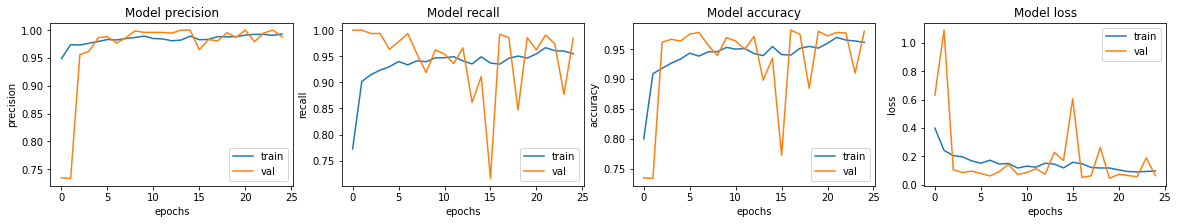

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_only_BN.history[met])
    ax[i].plot(history_only_BN.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#model.load_weights("best_model_only_BN.h5")

loss, accuracy, precision, recall = model_only_BN.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

**이번에는 dropout만 사용해보자! [모델 (7)]**

In [53]:
def dense_block_D(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model_only_DO():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_D(512, 0.7),
        dense_block_D(128, 0.5),
        dense_block_D(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [56]:
mc_DO = tf.keras.callbacks.ModelCheckpoint('best_model_only_DO.h5', monitor='val_loss', mode='min', save_best_only=True)

with tf.device('/GPU:0'):
    model_only_DO = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_only_DO.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    history_only_DO = model_only_DO.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc_DO]
    )



Epoch 1/25
261/261 [==============================] - 115s 375ms/step - loss: 0.3990 - accuracy: 0.8175 - precision: 0.9599 - recall: 0.7874 - val_loss: 0.5987 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 97s 373ms/step - loss: 0.2532 - accuracy: 0.8954 - precision: 0.9717 - recall: 0.8851 - val_loss: 0.9151 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 98s 377ms/step - loss: 0.2200 - accuracy: 0.9174 - precision: 0.9775 - recall: 0.9099 - val_loss: 0.5580 - val_accuracy: 0.7462 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 100s 384ms/step - loss: 0.2068 - accuracy: 0.9219 - precision: 0.9737 - recall: 0.9198 - val_loss: 0.3600 - val_accuracy: 0.8625 - val_precision: 1.0000 - val_recall: 0.8128
Epoch 5/25
261/261 [==============================] - 102s 393ms/step - loss: 0.1762 - acc

결과를 시각화 하고 metric 값들을 출력해보자

39/39 [==============================] - 10s 242ms/step - loss: 0.8875 - accuracy: 0.7756 - precision: 0.7413 - recall: 0.9846
Loss: 0.8875324726104736,
Accuracy: 0.7756410241127014,
Precision: 0.7413127422332764,
Recall: 0.9846153855323792


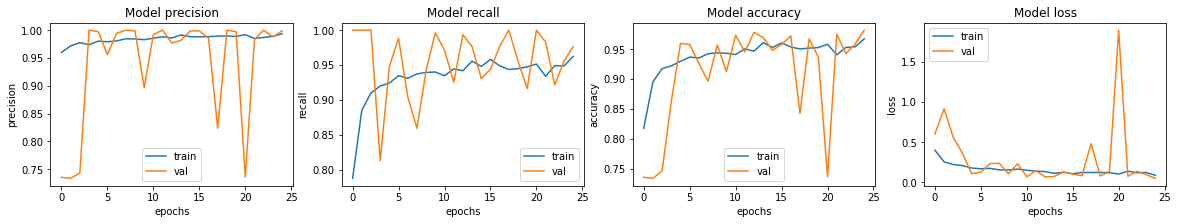

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_only_DO.history[met])
    ax[i].plot(history_only_DO.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#model_only_DO.load_weights("best_model_only_DO.h5")

loss, accuracy, precision, recall = model_only_DO.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

결과에서 볼 수 있듯이 오히려 Batch nomalization과 Dropout을 모두 쓴 모델보다 각각 하나씩만 쓴 모델의 성능이 현저히 떨어진다.  
**다른 방법을 생각해봐야한다.**

**모델 설계 과정에서 Conv2D 레이어 이후에 batch normalization을 넣고 모든 conv_block 뒤에 dropout을 넣는다면? [모델 (8)]**

In [66]:
def build_model_BN_DO():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        
        conv_block(32),
        tf.keras.layers.Dropout(0.2),
        conv_block(64),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [67]:
with tf.device('/GPU:0'):
    model_BN_DO = build_model_BN_DO()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_BN_DO.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    history_BN_DO = model_BN_DO.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[mc]
    )

Epoch 1/25
261/261 [==============================] - 124s 406ms/step - loss: 0.5044 - accuracy: 0.7524 - precision: 0.9256 - recall: 0.7254 - val_loss: 0.8319 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 104s 399ms/step - loss: 0.2995 - accuracy: 0.8714 - precision: 0.9616 - recall: 0.8616 - val_loss: 2.1502 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 102s 392ms/step - loss: 0.2548 - accuracy: 0.8951 - precision: 0.9697 - recall: 0.8867 - val_loss: 0.1016 - val_accuracy: 0.9702 - val_precision: 0.9742 - val_recall: 0.9856
Epoch 4/25
261/261 [==============================] - 105s 401ms/step - loss: 0.2162 - accuracy: 0.9155 - precision: 0.9758 - recall: 0.9090 - val_loss: 1.3771 - val_accuracy: 0.7365 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 107s 410ms/step - loss: 0.1935 - a

39/39 [==============================] - 9s 238ms/step - loss: 0.7812 - accuracy: 0.8013 - precision: 0.7737 - recall: 0.9641
Loss: 0.7811722755432129,
Accuracy: 0.8012820482254028,
Precision: 0.7736625671386719,
Recall: 0.964102566242218


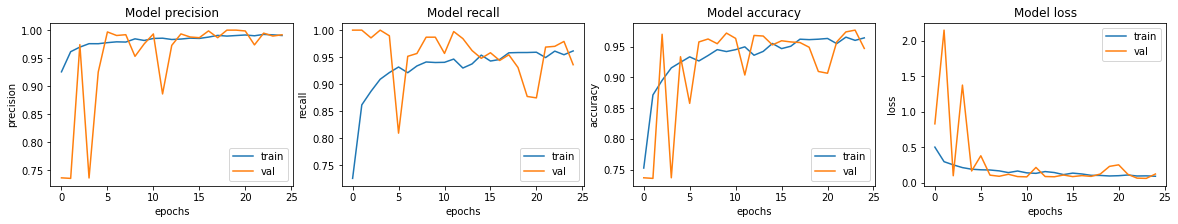

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_BN_DO.history[met])
    ax[i].plot(history_BN_DO.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model_BN_DO.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

역시나 기존 모델보다 좋지 않은 값이 나왔다.

---
---

# 회고

* 결과적으로 val 데이터가 매우 작다보니 늘려서 사용했는데, 그럼에도 많은 데이터는 아니다.  
그래서 val 데이터에 대한 loss나 accuracy가 진동하는 것을 볼 수 있었지만,  
test 데이터에 대한 결과에서는 ```ImageDataGenerator```를 이용하여 좋은 결과를 얻었다.  
네트워크의 경우 노드에 나와있는(Kaggle에서 제시한) 모델로 잘 설계되었다.

* 여러가지 방법으로 성능을 확인해봤다.  
> (1) data augmentation을 포함한 기본 모델  
(2) 모델 (1) + 옵티마이저: RMSProp  
(3) 모델 (2) + data augmentation 제외  
(4) 모델 (2) + train, val 데이터 재정립 제외(기본 개수 사용)  
(5) 모델 (2) + ```ImageDataGenerator``` 활용  
(추가테스트 - batch normalization과 dropout의 상관관계 확인을 위함)  
(6) 모델 (1) -> Dense 레이어에서 batch normalization만 사용  
(7) 모델 (1) -> dropout만 사용  
(8) 모델 (1) -> 모든 Conv2D 레이어 뒤에 batch normalization 추가, 모든 conv_block 뒤에 dropout을 추가  

* 결과적으로 모델 (5)가 87.8%의 test accuracy와 98%의 test recall을 기록하며 가장 좋은 성능을 보였다.  
그리고 모델 (2)가 82%의 test accuracy와 96%의 test recall을 기록하며 두번째도 높은 성능을 보였다.  
그 외에는 의미없는 80% 이하의 accuracy를 보이며 거의 비슷한 성능을 보인다.  
아무래도 데이터의 수가 적다보니 의미있는 개선을 하는 것이 어려운 것 아닌가 하는 생각이 든다.

* data augmentation을 적용하고, optimizer를 RMSProp으로 설정 후, ```ImageDataGenerator```를 사용한 결과에서  
test accuracy 87%를 만족했다.  
사실, 병을 진단하는 것에서는 무엇보다도 false negative를 줄이고 true positive를 높이는 것이 중요하다고 생각하므로,  
recall 값이 중요하다. ${(recall=\frac{True Positive}{True Positive+False Negative})}$  
그런 의미에서 recall도 98%를 만족하며 좋은 성능을 기록했다.

* ```ImageDataGenerator```에 대해서 처음 접해봤는데, data augmentation을 할 때 굉장히 좋은 방법은 것 같다.  
새로운 방법이기에 처음 적용하는데 어려움이 있었지만 tensorflow 공식 문서를 잘 읽어보고 적용할 수 있었다.  
또한, 노드에서 언급하길 일반적으로 batch nomalization과 dropout을 같이 사용하지 않는다고 했는데,  
구글링을 하며 본 네트워크들에서는 대부분 함께 사용하고 있었으며, 일부는 둘 다 사용하지 않는 것이 이상하다고 설명하고 있다.  
이 부분에 대해서 조금 더 알아본다면 향후 프로젝트에서도 도움이 될 것이라 생각한다.